In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random as rand
import keras
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

Using TensorFlow backend.
C:\Users\1\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\1\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\1\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\1\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarn

In [2]:
img_path = 'data/gen1/train/images/'
mask_path = 'data/gen1/train/masks/'
train_df = [(img_path + str(i) + '.jpg', mask_path + str(i) + '.jpg') for i in range(100000)]
train_df = np.array(train_df)
train_df.shape

(100000, 2)

In [3]:
img_path = 'data/gen1/val/images/'
mask_path = 'data/gen1/val/masks/'
val_df = [(img_path + str(i) + '.jpg', mask_path + str(i) + '.jpg') for i in range(10000)]
val_df = np.array(val_df)
val_df.shape

(10000, 2)

In [4]:
img_path = 'data/gen1/test/images/'
mask_path = 'data/gen1/test/masks/'
test_df = [(img_path + str(i) + '.jpg', mask_path + str(i) + '.jpg') for i in range(10000)]
test_df = np.array(test_df)
test_df.shape

(10000, 2)

In [5]:
kol_path = 'data/gen1/kol/'
kol_df = [kol_path + str(i) + '.npy' for i in range(1000)]
kol_df = np.array(kol_df)
kol_df.shape

(1000,)

In [6]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_num = rand.randint(0, gen_df.shape[0] - 1)
            img_name, mask_name = gen_df[img_num]
            img = cv2.imread(img_name)
            mask = cv2.imread(mask_name)
            
            #img = cv2.resize(img, (256, 256))
            #mask = cv2.resize(mask, (256, 256))
            mask = mask[:,:,0]
            tmp = np.array(mask)
            mask[tmp>128] = 1
            mask[tmp<=128] = 0
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [7]:
for x, y in keras_generator(train_df, 16):
    break


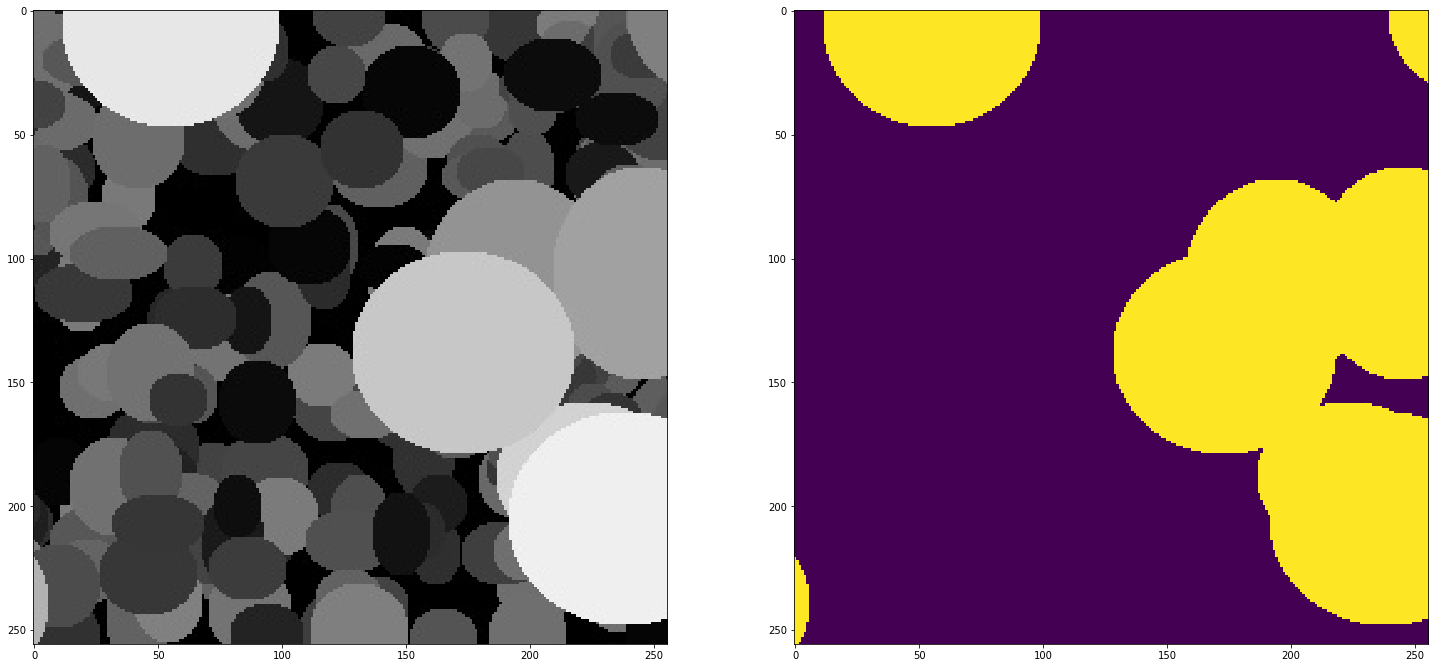

In [8]:
im_id = 10
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
imgz = y[im_id, ..., 0]
imgz = imgz
axes[1].imshow(imgz)
plt.show()

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [8]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
batch_size = 2
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=200,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)                     


Epoch 1/200


KeyboardInterrupt: 

In [9]:
model.load_weights('checkpoints/my_checkpoint2')

In [13]:
pred = model.predict(x)

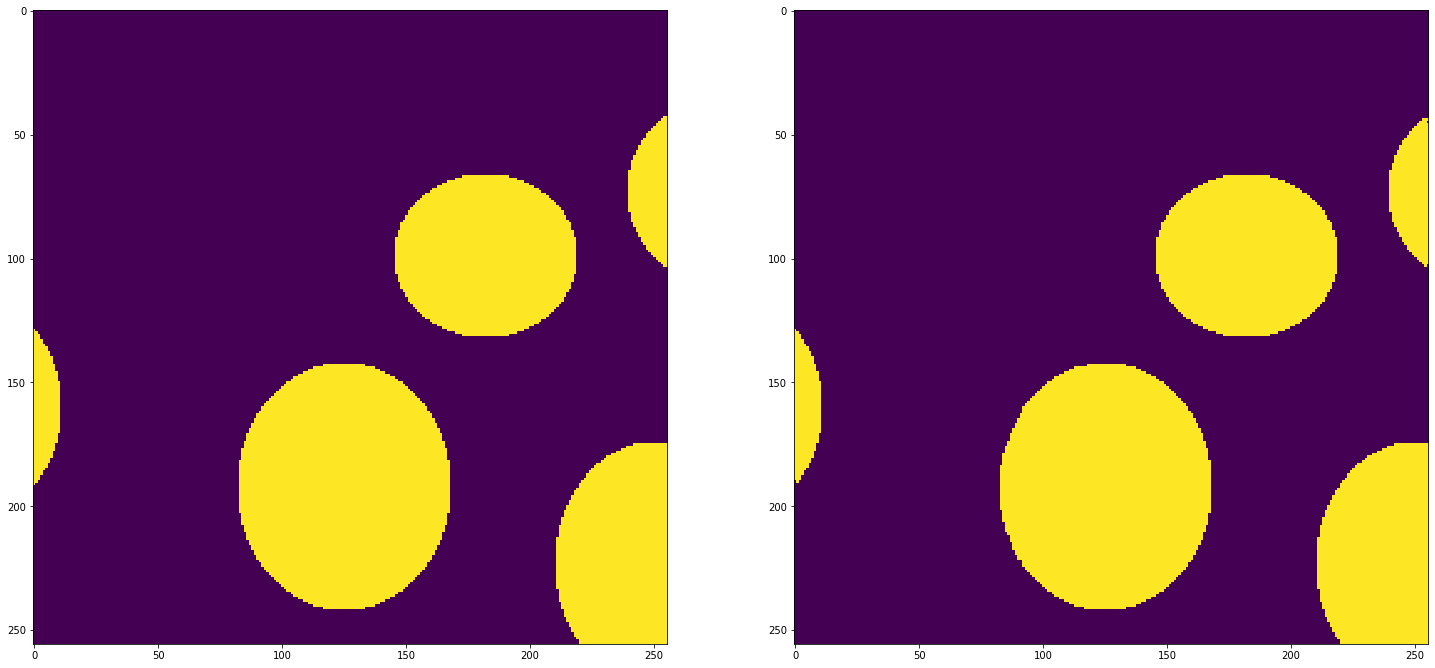

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
im_id = 15
axes[0].imshow(y[im_id, ..., 0])
t_mask = pred[im_id, ..., 0]>0.9
axes[1].imshow(t_mask)
plt.show()

In [113]:
model.save_weights('checkpoints/my_checkpoint2')

In [59]:
loss,acc = model.evaluate(x,  y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

TypeError: cannot unpack non-iterable float object

In [15]:
img = cv2.imread('pres16.jpg')
img = cv2.resize(img,(256,256))
img = np.expand_dims(img, 0)
img.shape

(1, 256, 256, 3)

In [16]:
pred = model.predict(img / 255)

In [114]:

pred = model.predict(keras_generator(val_df,1000)[0])

TypeError: 'generator' object is not subscriptable

In [115]:
mask1 = pred[12, ..., 0]>0.5
distance = ndi.distance_transform_edt(mask1, sampling = 0.5)
expand = np.zeros((296,296))
expand[20:276,20:276]=distance
local_maxi_coord = peak_local_max(expand, footprint=np.ones((17, 17)))
print(local_maxi_coord.shape)
local_maxi = np.zeros((256,256))
for coord in local_maxi_coord:
    local_maxi[coord[0]-20,coord[1]-20] = 1
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=mask1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(labels)
print(np.unique(labels))
axes[1].imshow(mask1)
plt.show()

IndexError: index 12 is out of bounds for axis 0 with size 1

In [27]:
val_df[0:100]

array([['data/gen/val/images/0.jpg', 'data/gen/val/masks/0.jpg'],
       ['data/gen/val/images/1.jpg', 'data/gen/val/masks/1.jpg'],
       ['data/gen/val/images/2.jpg', 'data/gen/val/masks/2.jpg'],
       ['data/gen/val/images/3.jpg', 'data/gen/val/masks/3.jpg'],
       ['data/gen/val/images/4.jpg', 'data/gen/val/masks/4.jpg'],
       ['data/gen/val/images/5.jpg', 'data/gen/val/masks/5.jpg'],
       ['data/gen/val/images/6.jpg', 'data/gen/val/masks/6.jpg'],
       ['data/gen/val/images/7.jpg', 'data/gen/val/masks/7.jpg'],
       ['data/gen/val/images/8.jpg', 'data/gen/val/masks/8.jpg'],
       ['data/gen/val/images/9.jpg', 'data/gen/val/masks/9.jpg'],
       ['data/gen/val/images/10.jpg', 'data/gen/val/masks/10.jpg'],
       ['data/gen/val/images/11.jpg', 'data/gen/val/masks/11.jpg'],
       ['data/gen/val/images/12.jpg', 'data/gen/val/masks/12.jpg'],
       ['data/gen/val/images/13.jpg', 'data/gen/val/masks/13.jpg'],
       ['data/gen/val/images/14.jpg', 'data/gen/val/masks/14.jpg'],


[0 1 2 3 4]


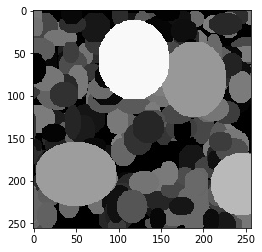

In [77]:
t = test_df[2999][0]
im = cv2.imread(t)
im_write = np.array(im)
#im = cv2.resize(im, (256,256))/255
#im_write = cv2.resize(im_write, (256,256))
pred = model.predict(np.array([im])/255)

mask1 = pred[0, ..., 0]>0.9
distance = ndi.distance_transform_edt(mask1, sampling = 0.5)
expand = np.zeros((296,296))
expand[20:276,20:276]=distance
local_maxi_coord = peak_local_max(expand, footprint=np.ones((20, 20)))
local_maxi = np.zeros((256,256))
for coord in local_maxi_coord:
    local_maxi[coord[0]-20,coord[1]-20] = 1
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=mask1)
print(np.unique(labels))

for k in np.unique(labels):
    R = rand.randint(0,255)
    G = rand.randint(0,255)
    B = rand.randint(0,255)
    if k == 0:
        continue
    #im_write[labels == k,:] = [R,G,B]
plt.imshow(im_write)

In [75]:
matr = np.zeros((6,6))
matr [3,3] = 1
print(matr)
for ind in range(2):
    for jnd in range(2):
        i = ind
        j = jnd
        s1 = np.sum(matr[i+1:i+4,j+1:j+4])
        s2 = np.sum(matr[i,j:j+5]) + np.sum(matr[i+4,j:j+5]) + np.sum(matr[i:i+5,j]) + np.sum(matr[i:i+5,j+4]) 
        if (s1 != 0) and (s2 == 0):
            matr[i:i+5,j:j+5] = 0
matr

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

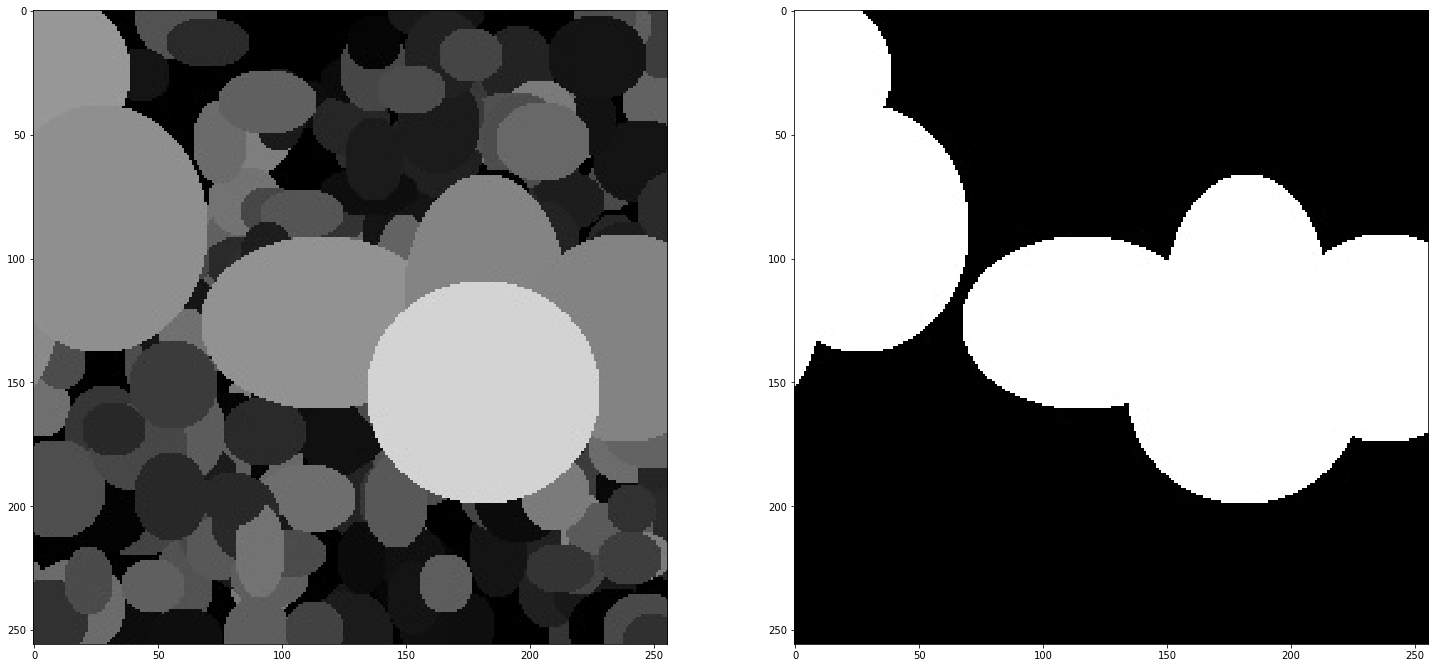

In [188]:
img_name, mask_name = test_df[260]
img = cv2.imread(img_name)
mask = cv2.imread(mask_name)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask)
plt.show()

In [125]:
colors = []
for k in range (1000):
    R = rand.randint(0,255)
    G = rand.randint(0,255)
    B = rand.randint(0,255)
    colors += [[R,G,B]]
#colors
class_color = np.zeros(1000)
class_color = [i for i in range(1000)]
last_frame = np.zeros((256,256))
last_color = np.zeros(1000)
fl = False


In [126]:
from datetime import datetime
t11 = []
t22 = []



In [127]:
test = test_df[4000:4999]
fheight = 256
fwidth = 256
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('videos/out_modeln4.avi',fourcc, 20.0, (fwidth,fheight))
out1 = cv2.VideoWriter('videos/modeln4.avi',fourcc, 20.0, (fwidth,fheight))
miou = []
classes = []
ind = 0
obj = 0
mas = np.load(kol_path + '4.npy')
for t, t1 in test:
    im = cv2.imread(t)
    im_mask = cv2.imread(t1)
    im_write = np.array(im)
    #im = cv2.resize(im, (256,256))/255
    #im_write = cv2.resize(im_write, (256,256))
        
    num_og = mas[ind]
    ind += 1
    s1 = datetime.now()
    pred = model.predict(np.array([im])/255)
    t11.append(datetime.now()-s1)
    im_mask = im_mask[:,:,0]
    tmp = np.array(im_mask)
    im_mask[tmp>128] = 1
    im_mask[tmp<=128] = 0
    
    mask1 = pred[0, ..., 0]>0.9
    n1 = mask1 + im_mask
    n1[n1 > 0] = 1
    n2 = im_mask * mask1
    #print (n1, n2)
    miou.append((np.sum(n2)+0.0000001)/(np.sum(n1)+0.0000001))
    """
    for ind in range(251):
        for jnd in range(251):
            i = ind
            j = jnd
            s1 = np.sum(mask1[i+1:i+4,j+1:j+4])
            s2 = np.sum(mask1[i,j:j+5]) + np.sum(mask1[i+4,j:j+5]) + np.sum(mask1[i:i+5,j]) + np.sum(mask1[i:i+5,j+4]) 
            if (s1 != 0) and (s2 == 0):
                mask1[i:i+5,j:j+5] = 0
    """
    s2 = datetime.now()
    distance = ndi.distance_transform_edt(mask1, sampling = 0.5)
    exp_val = 50
    expand = np.zeros((256+exp_val*2,256+exp_val*2))
    expand[exp_val:256+exp_val,exp_val:256+exp_val]=distance
    local_maxi_coord = peak_local_max(expand, footprint=np.ones((20, 20)))
    local_maxi = np.zeros((256,256))
    for coord in local_maxi_coord:
        local_maxi[coord[0]-exp_val,coord[1]-exp_val] = 1
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=mask1)
    
    if fl: 
        f = np.zeros(obj)
        for label in np.unique(labels):
            if label == 0:
                continue
            tmp = np.zeros((256,256))
            tmp[tmp == 0] = -1
            tmp[labels == label] = last_frame[labels == label]
            elements, repeats = np.unique(tmp, return_counts=True)
            index = repeats.argmax()
            repeats[index] = 0
            index = repeats.argmax()
            elem = int(elements[index])
            if elem != 0:
                if f[last_color[elem]] != 1:
                    class_color[label] = last_color[elem]
                    f[last_color[elem]] = 1
                else:
                    class_color[label] = obj
                    obj += 1
            else:
                class_color[label] = obj
                obj += 1
    else:
        obj = np.unique(labels).shape[0]
    
    last_frame = np.array(labels)
    last_color = np.array(class_color)
    fl = True
    #print(np.unique(labels))
    num_res = np.unique(labels).shape[0] - 1
    classes.append((min(num_og, num_res)+0.0001)/(max(num_og, num_res)+0.0001))
    for k in np.unique(labels):
        if k == 0:
            continue
        im_write[labels == k,:] = colors[class_color[k]]
    t22.append(datetime.now()-s2)
    cv2.imshow('frame',im_write)
    out.write(im_write)
    out1.write(im)
    #print(num_res, num_og, classes[len(classes)-1])
    k = cv2.waitKey(1)
    if k == 27:         # If escape was pressed exit
        cv2.destroyAllWindows()
        break
out.release()
out1.release()
cv2.destroyAllWindows()

In [101]:
len(miou)

999

In [102]:
m = np.array(miou)
np.sum(m)/m.shape[0]

0.9921433403344617

In [103]:
c = np.array(classes)
np.sum(c)/1000

0.8971791714455096

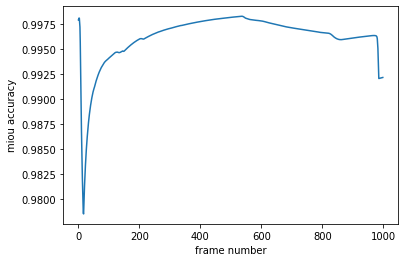

In [104]:
gr = []
for i in range(m.shape[0]):
    gr.append(np.sum(m[0:i+1])/(i+1))
plt.xlabel('frame number')
plt.ylabel('miou accuracy')
plt.plot([i for i in range(999)], gr)

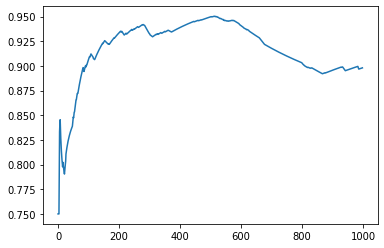

In [105]:
gr = []
for i in range(c.shape[0]): 
    gr.append(np.sum(c[0:i+1])/(i+1))
plt.plot([i for i in range(999)], gr)

In [115]:
min(miou)

0.9617077464790265

In [116]:
!python --version

Python 3.7.6


In [128]:
t11 = np.array(t11)
np.sum(t11) / t11.shape[0]

datetime.timedelta(microseconds=355285)

In [129]:
t22 = np.array(t22)
np.sum(t22) / t22.shape[0]

datetime.timedelta(microseconds=46500)

In [130]:
0.046 + 0.362

0.408